# Lab02: Ensemble Methods using CustomerChurnData

## Random forests on customer churn dataset

*  We will train a random forest classifier on the telecom customer churn dataset <br>
*  The objective is to predict customer churn (true or false) based on the customers' service usage attributes in the dataset <br>
(Some parts of the code in this section are adopted from Reference [1])

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Suppress warnings about too few trees from the early models
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

## 1. Data exploration and preparation

We are already familiar with the dataset from our last practical. As random forests and Extra-trees are decision tree-based models, the data preparation requirements are the same as for decision trees. Here, we will quickly go through the same steps as we did in the last practical to prepare the dataset. <br>
* Import the customer churn data <br>
* Remove the columns that are unlikely to be useful for prediction <br>
* Encode nominal data ('yes'/'no') to boolean values <br>

In [2]:
#upload data to colab if you use google colab
from google.colab import files
data_to_load = files.upload()
data = pd.read_csv('Orange_Telecom_Churn_Data.csv')
data.head()

Saving Orange_Telecom_Churn_Data.csv to Orange_Telecom_Churn_Data.csv


,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Remove the attribues `state`, `phone_number` and `area_code` as they are unlikely to be useful predictors

In [3]:
data.drop(['state', 'phone_number', 'area_code'], axis=1, inplace=True)
data.head()

,account_length,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,128,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,107,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,137,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,84,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,75,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Encode `intl_plan` and `voice_mail_plan` as True/False as tree-based models in Scikit-Learn are unable to handle categorical data

In [4]:
for col in ['intl_plan', 'voice_mail_plan']:
    data[col] = data[col].replace('yes',True).replace('no',False).astype(bool)  #np.bool
      
data[['intl_plan', 'voice_mail_plan']].dtypes

intl_plan          bool
voice_mail_plan    bool
dtype: object

In [5]:
data.head().T

,0,1,2,3,4
account_length,128,107,137,84,75
intl_plan,False,False,False,True,True
voice_mail_plan,True,True,False,False,False
number_vmail_messages,25,26,0,0,0
total_day_minutes,265.1,161.6,243.4,299.4,166.7
total_day_calls,110,123,114,71,113
total_day_charge,45.07,27.47,41.38,50.9,28.34
total_eve_minutes,197.4,195.5,121.2,61.9,148.3
total_eve_calls,99,103,110,88,122
total_eve_charge,16.78,16.62,10.3,5.26,12.61


As the dataset is skewed (about 86% are non-churned customers), we will apply stratified split to divide the dataset into the training and test sets

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

# Separate feature columns and the target column
feature_cols = [x for x in data.columns if x != 'churned']

# Split the data into two parts with 1500 points in the test data

# This creates a generator
strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=1500, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_cols], data['churned']))

# Create the data sets
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'churned']

X_test = data.loc[test_idx, feature_cols]
y_test = data.loc[test_idx, 'churned']

In [7]:
y_train.value_counts()

False    3005
True      495
Name: churned, dtype: int64

In [8]:
y_train.value_counts(normalize=True)

False    0.858571
True     0.141429
Name: churned, dtype: float64

In [9]:
y_test.value_counts()

False    1288
True      212
Name: churned, dtype: int64

In [10]:
y_test.value_counts(normalize=True)

False    0.858667
True     0.141333
Name: churned, dtype: float64

## 2. Random forests

* Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models <br>
* Plot the resulting oob errors as a function of the number of trees <br>
* Since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time <br>
* Use the `set_params` method to update the number of trees

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
# Note that the number of trees is not setup here
# using oob for model evaluation
# ?RandomForestClassifier
rf_clf = RandomForestClassifier(oob_score=True, 
                                random_state=42, 
                                warm_start=True,
                                n_jobs=-1)

oob_list = list()

# Iterate through a range of numbers of trees
for n_trees in [10, 50, 100, 500, 600, 800, 1000, 1100, 1200, 1300, 1400, 1500]:
    # Use this to set the number of trees
    rf_clf.set_params(n_estimators=n_trees)

    # Fit the model
    rf_clf.fit(X_train, y_train)

    # Get the oob error
    oob_error = 1 - rf_clf.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob = pd.concat(oob_list, axis=1).T.set_index('n_trees')
rf_oob

,oob
n_trees,
10.0,0.073429
50.0,0.049143
100.0,0.045143
500.0,0.043429
600.0,0.043143
800.0,0.043714
1000.0,0.042857
1100.0,0.042571
1200.0,0.043429


Question: What is the optimal number of Trees?

The error appears to have stabilized from around 1100 trees <br>
Plot the graph for easy visualization

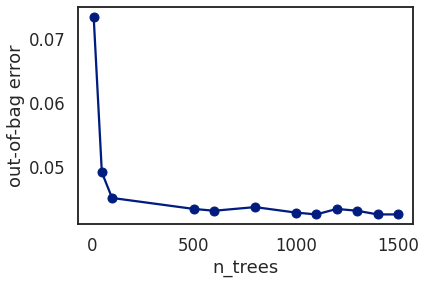

In [12]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = rf_oob.plot(legend=False, marker='o')
ax.set(ylabel='out-of-bag error');

## 3. Evaluation of random forest classifier

In [13]:
# defime a measure_error function for summarize various errors together
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred),
                      'recall': recall_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred)},
                      name=label)

We choose the random forest model <br>
First, instantiate a random forest with 1100 base estimators that gives the lowest oob error

In [14]:
# Random forest with 1100 estimators

rf_clf = rf_clf.set_params(n_estimators=1100, warm_start=False)

As in decision trees, we can plot the feature importances <br>
They are not exactly, but more or less, the same as those obtained from the decision trees in the last practical

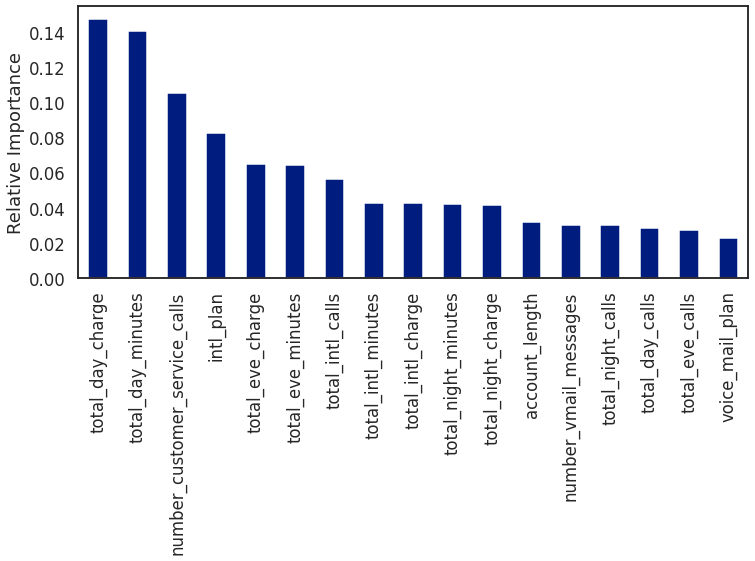

In [15]:
feature_imp = pd.Series(rf_clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
fig = plt.figure(figsize=(12,5))
ax = feature_imp.plot(kind='bar')
ax.set(ylabel='Relative Importance');

Let's evaluate the performance of the random forest model using cross-validation

In [23]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(rf_clf, X_train, y_train, cv=5, method="predict")
y_train_pred_prob = cross_val_predict(rf_clf, X_train, y_train, cv=5, method="predict_proba")

Compute the error metrics on cross-validation results

In [24]:
train_error = pd.concat([measure_error(y_train, y_train_pred, 'train')],
                         axis=1)

train_error

,train
accuracy,0.953143
precision,0.941333
recall,0.713131
f1,0.811494


Compute the confusion matrix

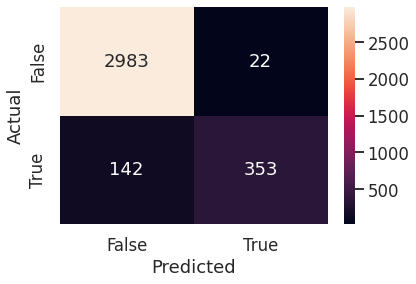

In [25]:
cm = confusion_matrix(y_train, y_train_pred)

sns.set_context('talk')
ax = sns.heatmap(cm, annot=True, fmt='d')
labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [26]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97      3005
        True       0.94      0.71      0.81       495

    accuracy                           0.95      3500
   macro avg       0.95      0.85      0.89      3500
weighted avg       0.95      0.95      0.95      3500



What would be the performance of this classifier on the test set?

In [27]:
y_test_pred = rf_clf.predict(X_test)

In [28]:
test_error = pd.concat([measure_error(y_test, y_test_pred, 'test')],
                       axis=1)

test_error

,test
accuracy,0.958000
precision,0.930636
recall,0.759434
f1,0.836364


The results are comparable with the test results of optimized decision tree models built in the last practical, but recall for positive class (churned customers) is still not great

#4. Let try with XGBoost and LightGBM (Optional)